In [1]:
!pip install confluent-Kafka
!pip install pyspark
!pip install spark-sql-kafka
!pip install kafka-python
!pip install pyspark==3.1.1
!pip install confluent-kafka[avro]==1.7.0
!pip install kafka-python
!pip install confluent-kafka


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 35.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=06b270f9385af275b47c977effc2f803e02d4c219d60324d1bec53fa5e282871
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement spark-sql-kafka (from versions: none)
ERROR: No matching distribution found for spark-sql-kafka
Looking in indexes: https://pypi.org/simple, http

In [10]:
# Confluent Cloud configurations

conf = {
    'bootstrap.servers': bootstrap_servers,
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': sasl_username,
    'sasl.password': sasl_password,
    'group.id': 'my-consumer-group',  # Specify a unique consumer group ID
    'auto.offset.reset': 'latest'  # Start consuming from the latest offset
}

In [ ]:
#Importing the necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, window, current_timestamp, sum
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from confluent_kafka import Consumer, KafkaException
from confluent_kafka import Producer as KafkaProducer
from pyspark.sql.streaming import StreamingQueryException
from confluent_kafka import Producer
import time
import random

# Kafka producer configuration
bootstrap_servers = 'pkc-lzvrd.us-west4.gcp.confluent.cloud:9092'
sasl_username = 'ATT27BW7IKWVVS7C'
sasl_password = 'N+mQd+xm1CRv4GhKgoMTWpAXISNzLudR0w+VW/SACm7AW6JSjntN1Fgz0nwSKaA8'
topic_name = 'network-traffic'

conf = {
    'bootstrap.servers': bootstrap_servers,
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': sasl_username,
    'sasl.password': sasl_password
}

producer = Producer(conf)

# Generate and publish network traffic data to Kafka topic
while True:
    # Generate random network traffic data
    source_ip = '.'.join(str(random.randint(0, 255)) for _ in range(4))
    destination_ip = '.'.join(str(random.randint(0, 255)) for _ in range(4))
    bytes_sent = random.randint(1000, 100000)

    # Publish network traffic data to Kafka topic
    message = f"{source_ip},{destination_ip},{bytes_sent}".encode('utf-8')
    producer.produce(topic_name, value=message)

    # Wait for the message to be delivered to Kafka
    producer.flush()

    # Wait for 1 second before generating next network traffic data
    time.sleep(1)


Creating a Spark Dataframe from the processed data

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.utils import StreamingQueryException
from confluent_kafka import Consumer, KafkaException

# Create a SparkSession
spark = SparkSession.builder \
    .appName("KafkaDataFrame") \
    .getOrCreate()

# Define the schema for the messages
schema = StructType([
    StructField("source_ip", StringType(), nullable=True),
    StructField("destination_ip", StringType(), nullable=True),
    StructField("bytes_sent", IntegerType(), nullable=True)
])

# Configure Kafka consumer
bootstrap_servers = 'pkc-lzvrd.us-west4.gcp.confluent.cloud:9092'
sasl_username = 'ATT27BW7IKWVVS7C'
sasl_password = 'N+mQd+xm1CRv4GhKgoMTWpAXISNzLudR0w+VW/SACm7AW6JSjntN1Fgz0nwSKaA8'
topic_name = 'network-traffic'

conf = {
    'bootstrap.servers': bootstrap_servers,
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': sasl_username,
    'sasl.password': sasl_password,
    'group.id': 'my-consumer-group',  # Specify a unique consumer group ID
    'auto.offset.reset': 'latest'  # Start consuming from the latest offset
}

consumer = Consumer(conf)
consumer.subscribe([topic_name])

# Read data from Kafka topic every minute
try:
    while True:
        messages = consumer.consume(num_messages=100, timeout=60.0)
        if messages is None:
            continue

        for message in messages:
            if message is None:
                continue

            if message.error():
                raise KafkaException(message.error())

            value = message.value().decode('utf-8')
#            print(f"Received message: {value}")

            # Process the received message
            processed_data = [(value.split(',')[0], value.split(',')[1], int(value.split(',')[2]))]
            processed_df = spark.createDataFrame(processed_data, schema)


            processed_df.show()
            # Perform any further operations on the processed DataFrame
            # For example, you can write the data to a file or perform aggregations
            
except (KeyboardInterrupt, KafkaException, StreamingQueryException) as e:
    print(f"Error occurred: {e}")

finally:
    consumer.close()


+--------------+--------------+----------+
|     source_ip|destination_ip|bytes_sent|
+--------------+--------------+----------+
|76.192.150.143|200.81.173.167|     50331|
+--------------+--------------+----------+

+--------------+--------------+----------+
|     source_ip|destination_ip|bytes_sent|
+--------------+--------------+----------+
|103.35.216.107|  57.98.56.250|     34333|
+--------------+--------------+----------+

+------------+--------------+----------+
|   source_ip|destination_ip|bytes_sent|
+------------+--------------+----------+
|6.191.59.241|  92.127.9.121|      2378|
+------------+--------------+----------+

+------------+--------------+----------+
|   source_ip|destination_ip|bytes_sent|
+------------+--------------+----------+
|203.197.4.37|  31.55.14.119|     16503|
+------------+--------------+----------+

+--------------+--------------+----------+
|     source_ip|destination_ip|bytes_sent|
+--------------+--------------+----------+
|34.153.107.254| 150.82.131

Creating an incremental Dataframe from the processed data using Union

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from confluent_kafka import Consumer, KafkaException

# Create a SparkSession
spark = SparkSession.builder \
    .appName("KafkaDataFrame") \
    .getOrCreate()

# Define the schema for the messages
schema = StructType([
    StructField("source_ip", StringType(), nullable=True),
    StructField("destination_ip", StringType(), nullable=True),
    StructField("bytes_sent", IntegerType(), nullable=True)
])

# Configure Kafka consumer
bootstrap_servers = 'pkc-lzvrd.us-west4.gcp.confluent.cloud:9092'
sasl_username = 'ATT27BW7IKWVVS7C'
sasl_password = 'N+mQd+xm1CRv4GhKgoMTWpAXISNzLudR0w+VW/SACm7AW6JSjntN1Fgz0nwSKaA8'
topic_name = 'network-traffic'

conf = {
    'bootstrap.servers': bootstrap_servers,
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': sasl_username,
    'sasl.password': sasl_password,
    'group.id': 'my-consumer-group',  # Specify a unique consumer group ID
    'auto.offset.reset': 'latest'  # Start consuming from the latest offset
}

consumer = Consumer(conf)
consumer.subscribe([topic_name])

# Create an empty DataFrame to hold the processed data
processed_df = spark.createDataFrame([], schema)

# Read data from Kafka topic every minute
try:
    while True:
        messages = consumer.consume(num_messages=100, timeout=60.0)
        if messages is None:
            continue

        for message in messages:
            if message is None:
                continue

            if message.error():
                raise KafkaException(message.error())

            value = message.value().decode('utf-8')
#            print(f"Received message: {value}")

            # Process the received message
            processed_data = [(value.split(',')[0], value.split(',')[1], int(value.split(',')[2]))]
            processed_data_df = spark.createDataFrame(processed_data, schema)

            # Append the processed data to the existing DataFrame
            processed_df = processed_df.union(processed_data_df)

            # Perform any further operations on the processed DataFrame
            # For example, you can write the data to a file or perform aggregations
            
except (KeyboardInterrupt, KafkaException) as e:
    print(f"Error occurred: {e}")

finally:
    consumer.close()

# Show the final processed DataFrame
processed_df.show()


Writing the processed data to a kafka topic

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, sum, current_timestamp, window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from confluent_kafka import Consumer, KafkaException, Producer

# Create a SparkSession
spark = SparkSession.builder \
    .appName("RealTimeNetworkTrafficAnalysis") \
    .getOrCreate()

# Define the schema for the messages
schema = StructType([
    StructField("source_ip", StringType(), nullable=True),
    StructField("destination_ip", StringType(), nullable=True),
    StructField("bytes_sent", IntegerType(), nullable=True)
])

# Configure Kafka consumer and producer
bootstrap_servers = 'pkc-lzvrd.us-west4.gcp.confluent.cloud:9092'
sasl_username = 'ATT27BW7IKWVVS7C'
sasl_password = 'N+mQd+xm1CRv4GhKgoMTWpAXISNzLudR0w+VW/SACm7AW6JSjntN1Fgz0nwSKaA8'
network_traffic_topic = 'network-traffic'
processed_data_topic = 'processed-data'

consumer_conf = {
    'bootstrap.servers': bootstrap_servers,
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': sasl_username,
    'sasl.password': sasl_password,
    'group.id': 'my-consumer-group',  # Specify a unique consumer group ID
    'auto.offset.reset': 'latest'  # Start consuming from the latest offset
}

producer_conf = {
    'bootstrap.servers': bootstrap_servers,
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': sasl_username,
    'sasl.password': sasl_password
}

consumer = Consumer(consumer_conf)
producer = Producer(producer_conf)

consumer.subscribe([network_traffic_topic])

# Create an empty DataFrame to hold the processed data
processed_df = spark.createDataFrame([], schema)

# Read data from Kafka topic and perform real-time processing
try:
    while True:
        messages = consumer.consume(num_messages=100, timeout=60.0)
        if messages is None:
            continue

        for message in messages:
            if message is None:
                continue

            if message.error():
                raise KafkaException(message.error())

            value = message.value().decode('utf-8')
            print(f"Received message: {value}")

            # Process the received message
            processed_data = [(value.split(',')[0], value.split(',')[1], int(value.split(',')[2]))]
            processed_data_df = spark.createDataFrame(processed_data, schema)

            # Append the processed data to the existing DataFrame
            processed_df = processed_df.union(processed_data_df)

            # Perform window-based aggregation to identify anomalies
            windowed_df = processed_df.withColumn("timestamp", current_timestamp()) \
                .groupBy(window("timestamp", "1 minute"), "source_ip") \
                .agg(sum("bytes_sent").alias("total_bytes_sent"))

            # Publish the processed data to the 'processed-data' Kafka topic
            for row in windowed_df.collect():
                processed_message = f"{row['window']['start']},{row['window']['end']},{row['source_ip']},{row['total_bytes_sent']}"
                producer.produce(processed_data_topic, processed_message.encode('utf-8'))

        producer.flush()

except (KeyboardInterrupt, KafkaException) as e:
    print(f"Error occurred: {e}")

finally:
    consumer.close()
    producer.flush()
    producer.close()

# Stop the SparkSession
spark.stop()


Error occurred: 


AttributeError: ignored

Trying some few visualizations of the processed data using Python libraries

In [4]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


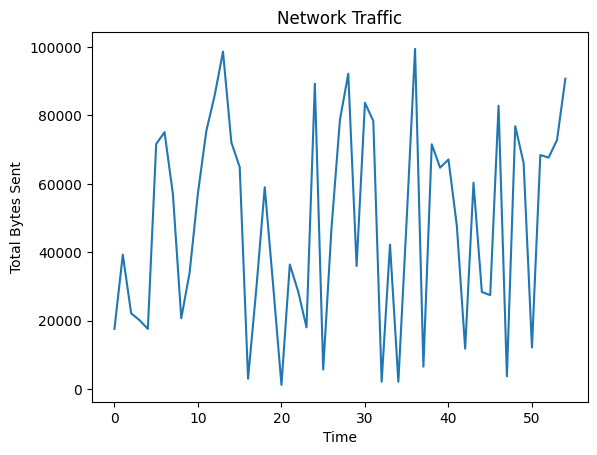

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'windowed_df' is the DataFrame containing processed data
pandas_df = windowed_df.toPandas()
x = range(len(pandas_df))
y = pandas_df['total_bytes_sent'].tolist()

plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Total Bytes Sent')
plt.title('Network Traffic')
plt.show()


In [7]:
import plotly.express as px
import pandas as pd

# Assuming 'windowed_df' is the DataFrame containing processed data
pandas_df = windowed_df.toPandas()

fig = px.line(pandas_df, x=pandas_df.index, y='total_bytes_sent', title='Network Traffic')
fig.show()


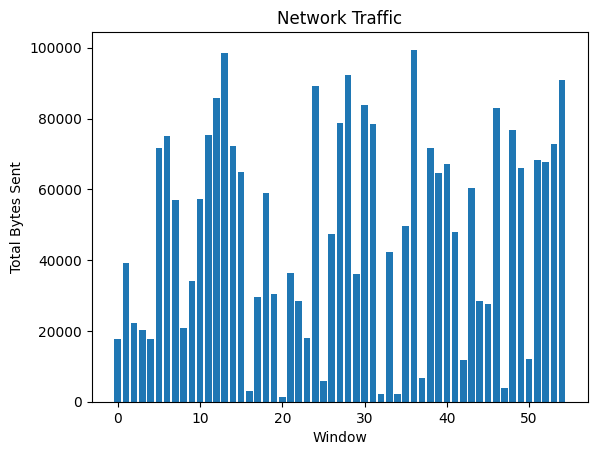

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'windowed_df' is the PySpark DataFrame containing processed data
pandas_df = windowed_df.toPandas()

x = range(len(pandas_df))
y = pandas_df['total_bytes_sent'].tolist()

plt.bar(x, y)
plt.xlabel('Window')
plt.ylabel('Total Bytes Sent')
plt.title('Network Traffic')

plt.show()
